In [1]:
#import all relevant packages
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian, KFAC, DiagGGNExact
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.nn import functional as F
#from torch.utils.data import Dataset
#from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
#from scipy.stats import pearsonr
#from mpl_toolkits.axes_grid1 import AxesGrid
#import mpl_toolkits as mpl
#from scipy.stats import chi2, norm
#import random
#import warnings
#warnings.filterwarnings("ignore")
from scipy.stats import pearsonr, linregress
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import random

#plt.rcParams["mpl_toolkits.legacy_colorbar"] = False

s=2
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#plt stuff
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
#scatterlist = []

## Define Perceptron

In [36]:
def NN(sz):
    
    features = torch.nn.Sequential(
        torch.nn.Linear(1, sz),
        #torch.nn.ReLU(),
        #torch.nn.Linear(sz, sz),
        #torch.nn.Linear(sz, sz),
        #torch.nn.Linear(sz, sz),
        #torch.nn.Linear(sz, sz), #good
        #torch.nn.Linear(sz, sz),
        #torch.nn.Linear(sz, sz),#good
        #torch.nn.Linear(sz, sz),
        #torch.nn.Linear(sz, sz),
        #torch.nn.Linear(sz, sz),
        #torch.nn.Linear(sz, sz),
        #torch.nn.ReLU(),
        torch.nn.Linear(sz, 1)
        #torch.nn.ReLU()
        
    )
    return(features)

net = NN(sz= 10)

lossfunction = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.5)

In [4]:
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()



## Create Dataset

In [5]:
class NumbersDataset(Dataset):
    
    def __init__(self):
        self.mean = 0
        self.std = 0.6 #0.6
        self.size = 500
        self.mult = 2
        self.noise = np.random.normal(loc=self.mean, scale=self.std, size=self.size)
        self.nums = np.linspace(-20, 30, self.size)
        #self.nums = self.nums + self.noise
        self.samples = []#torch.cat([self.nums + self.noise, 2*self.nums]).view(-1,2)
        for i, elem in enumerate(self.nums):
            self.samples.append((elem + self.noise[i] , elem *self.mult))
        #self.samples = torch.tensor(self.samples)
    def __noise__(self):
        return self.noise
    
    def __shape__(self):
        return self.samples.size()
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        num, label = self.samples[idx]
        return num, label
        #$return self.samples[idx]
    
    def __plot__(self):
        inpt = []
        targ = []
        for tuplee in self.samples:
            inpt.append(tuplee[0])
            targ.append(tuplee[1])
        plt.scatter(inpt, targ)
        #plt.show()

if __name__ == '__main__':
    dataset = NumbersDataset()
    trainset, testset = random_split(dataset, [400, 100])
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True)#, num_workers=2)
    testloader = DataLoader(testset, batch_size=5, shuffle=False, num_workers=2)
    #print(len(dataset
    #print(dataset[99])
    #print(dataset[0])
    for i, batch in enumerate(trainloader):
        if i > 0:
            break
        print(i, batch)
        

0 [tensor([  2.9329,   1.7419,  -9.4282,  30.9278,  22.1763,  20.7602, -14.6527,
          9.1161, -13.8113,  -1.4421,  -2.5735,  28.0198,   2.9677,  14.8308,
          2.1440,   9.6983,   1.9232,  18.0973,  -0.3855, -12.6450,  25.0416,
         -2.7838,  -9.0141,  -5.9111,   9.7346,   9.6750,  -4.8884,   1.1824,
         24.1446,  26.4592,  15.0500,  16.2557,  18.3039,  -7.8708,  25.4415,
        -13.4918, -10.1525,  23.1991,  -1.0655,  17.7084,  -8.9601, -19.3682,
        -17.7985,  17.9728,   4.8431, -14.1502,   1.0240,  11.3571,  20.0068,
         26.0604,  29.6785,   4.8800, -13.3779,  20.3681,  29.6888,  10.1893,
         -4.3366, -16.3709,  -5.8736, -13.9804,  -7.4211,  -0.9468,  24.1503,
          1.2415], dtype=torch.float64), tensor([  8.2966,   5.0902, -18.1563,  60.0000,  42.9659,  38.7575, -31.3828,
         18.9178, -27.5752,  -1.5230,  -6.1323,  55.7916,   5.4910,  31.3427,
          7.2946,  17.9158,   3.4870,  36.3527,  -1.9238, -26.1723,  51.3828,
         -5.1303, -1

In [6]:
dataset.__len__()

500

In [7]:
plt.rcParams["figure.figsize"] = (20,10)
#dataset.__plot__()

## Define training procedure

In [30]:
def trainloop():
    
    for epoch in range(100):
        for i, (inputs, targets) in enumerate(trainloader):
            X, Y = inputs.float(), targets.float()
            X, Y =  X.view(X.size(0), -1), Y.view(Y.size(0), -1)
            #print(X, Y)
            #print(X, Y)
            #X, Y = Variable(torch.FloatTensor([X]), requires_grad=True), Variable(torch.FloatTensor([Y]), requires_grad=False)
            optimizer.zero_grad()
            outputs = net(X)
            loss = lossfunction(outputs, Y)
            loss.backward()
            optimizer.step()
            if (i % 30 == 0):
                print("Epoch {} - loss: {}".format(epoch, loss.data.item()))
    

In [9]:
def flattenlist(lst):
    flat_list = []
    for sublist in lst:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [37]:
trainloop()

Epoch 0 - loss: 752.4392700195312
Epoch 1 - loss: 9.247199058532715
Epoch 2 - loss: 2.0873358249664307
Epoch 3 - loss: 1.2256230115890503
Epoch 4 - loss: 1.4535454511642456
Epoch 5 - loss: 1.802735447883606
Epoch 6 - loss: 1.7318087816238403
Epoch 7 - loss: 1.5475987195968628
Epoch 8 - loss: 1.602681279182434
Epoch 9 - loss: 0.8852176070213318
Epoch 10 - loss: 1.6626583337783813
Epoch 11 - loss: 1.131873369216919
Epoch 12 - loss: 2.4225921630859375
Epoch 13 - loss: 1.2482528686523438
Epoch 14 - loss: 1.741154670715332
Epoch 15 - loss: 1.4642665386199951
Epoch 16 - loss: 1.3358206748962402
Epoch 17 - loss: 1.1693044900894165
Epoch 18 - loss: 1.8260711431503296
Epoch 19 - loss: 1.4116451740264893
Epoch 20 - loss: 1.4467756748199463
Epoch 21 - loss: 2.275581121444702
Epoch 22 - loss: 1.6706252098083496
Epoch 23 - loss: 1.476200819015503
Epoch 24 - loss: 1.0909926891326904
Epoch 25 - loss: 1.605420470237732
Epoch 26 - loss: 1.7169970273971558
Epoch 27 - loss: 1.7737271785736084
Epoch 28 - 

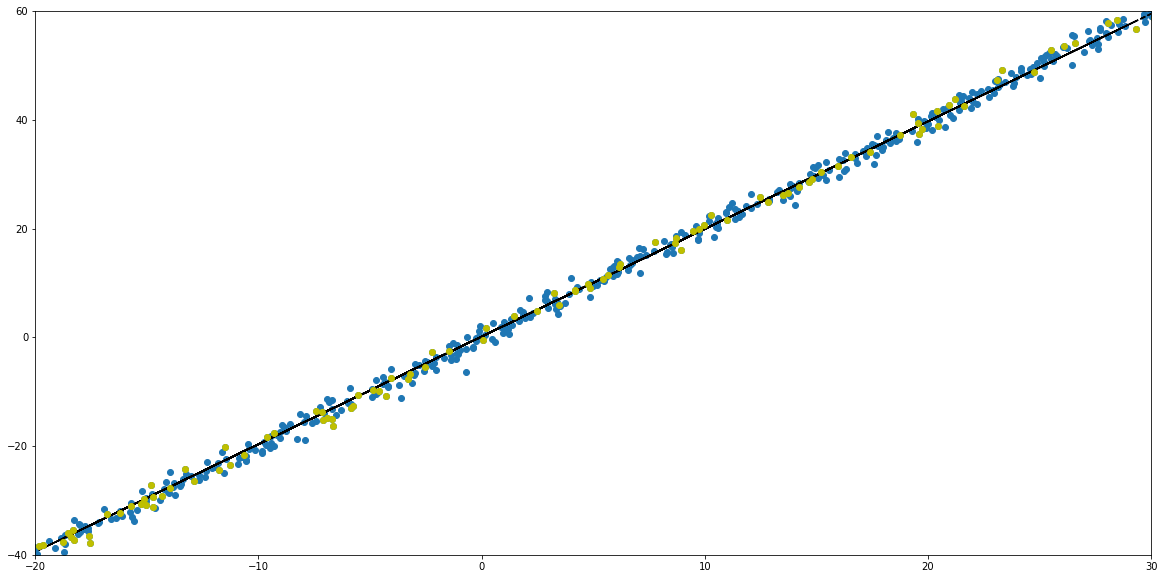

In [38]:
mpl.rcParams['agg.path.chunksize'] = 10000

inp = []
outp = []
targs = []
max_len = len(testloader)
for batch_idx, (inputs, targets) in enumerate(testloader):
        X, Y = inputs.float(), targets.float() #iter(data2)
        X, Y =  X.view(X.size(0), -1), Y.view(Y.size(0), -1)
        inp.append(X)
        targs.append(Y)
        output = net(X)
        outp.append(output)
inp, outp, targs = torch.tensor(flattenlist(inp)), torch.tensor(flattenlist(outp)), torch.tensor(flattenlist(targs))    


plt.plot(inp,outp, '--k')#, inp, targs, '--k')
plt.plot(inp,targs, 'yo')
dataset.__plot__()
plt.xlim(-20, 30)
plt.ylim(-40, 60)
plt.show()

In [12]:
#slope : slope of the regression line
#intercept : intercept of the regression line
#r-value : correlation coefficient
#p-value : two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero
#stderr : Standard error of the estimate

print('trained:')
print(linregress(inp,outp))
print()
print('dataset:')
print(linregress(inp,targs))

trained:
LinregressResult(slope=0.014130181917553055, intercept=0.5652673128343743, rvalue=0.999999999999988, pvalue=0.0, stderr=2.2103787961202198e-10)

dataset:
LinregressResult(slope=2.004775690290655, intercept=0.06571957926347594, rvalue=0.9991664133591979, pvalue=5.939624926904842e-138, stderr=0.008273985759510185)


### see if network trained correct weight

In [13]:
#print(list(net.named_parameters()))
#print()
#print(net(Variable(torch.Tensor([[[3]]]))))

## calculate Hessians: DiagHessian

In [33]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=True):
    lossfunc = lossfunction

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    max_len = len(train_loader)

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):
            
            
            if device == 'cuda':
                x, y = x.float().cuda(), y.long().cuda()
            else:
                x, y = torch.tensor(x).float(), torch.tensor(y).float()
            #print(x, y)

            model.zero_grad()
            x, y = x.view(-1, 1), y.view(-1, 1) 
                        
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #print(H_)
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance 

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))
    
    return(Cov_diag)

In [39]:
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)

parameter size:  torch.Size([10, 1])
parameter size:  torch.Size([10])
parameter size:  torch.Size([1, 10])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [40]:
print(perceptronDiagH)#[0].item())
#print(perceptronDiagGGN)

[tensor([[0.1843],
        [2.5623],
        [1.0103],
        [0.4229],
        [0.2225],
        [0.3011],
        [0.0813],
        [0.0793],
        [3.1066],
        [0.0812]]), tensor([2.0801, 3.1587, 3.1021, 2.8338, 2.2951, 2.5922, 1.1357, 1.1109, 3.1620,
        1.1340]), tensor([[1.2530, 0.0644, 0.0784, 0.2025, 0.1750, 0.0511, 0.0503, 0.0448, 0.3407,
         0.0464]]), tensor([0.6901])]


In [17]:
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))

tensor(3.1611)
tensor(3.1617)
tensor(3.1618)
tensor(3.1618)
tensor(3.1618)
tensor(3.1618)
tensor(3.1618)
tensor(3.1617)
tensor(3.1617)
tensor(3.1616)
tensor(3.1613)
tensor(2.9422)


In [18]:
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))

tensor(3.1611)
tensor(3.1617)
tensor(3.1618)
tensor(3.1618)
tensor(3.1618)
tensor(3.1618)
tensor(3.1618)
tensor(3.1617)
tensor(3.1617)
tensor(3.1616)
tensor(3.1613)
tensor(2.9422)


In [19]:
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))

tensor(3.1611)
tensor(3.1617)
tensor(3.1618)
tensor(3.1618)
tensor(3.1618)
tensor(3.1618)
tensor(3.1618)
tensor(3.1617)
tensor(3.1617)
tensor(3.1616)
tensor(3.1613)
tensor(2.9422)


In [20]:
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))

tensor(3.1611)
tensor(3.1617)
tensor(3.1618)
tensor(3.1618)
tensor(3.1618)
tensor(3.1618)
tensor(3.1618)
tensor(3.1617)
tensor(3.1617)
tensor(3.1616)
tensor(3.1613)
tensor(2.9422)


In [21]:
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))

tensor(3.1611)
tensor(3.1617)
tensor(3.1618)
tensor(3.1618)
tensor(3.1618)
tensor(3.1618)
tensor(3.1618)
tensor(3.1617)
tensor(3.1617)
tensor(3.1616)
tensor(3.1613)
tensor(2.9422)


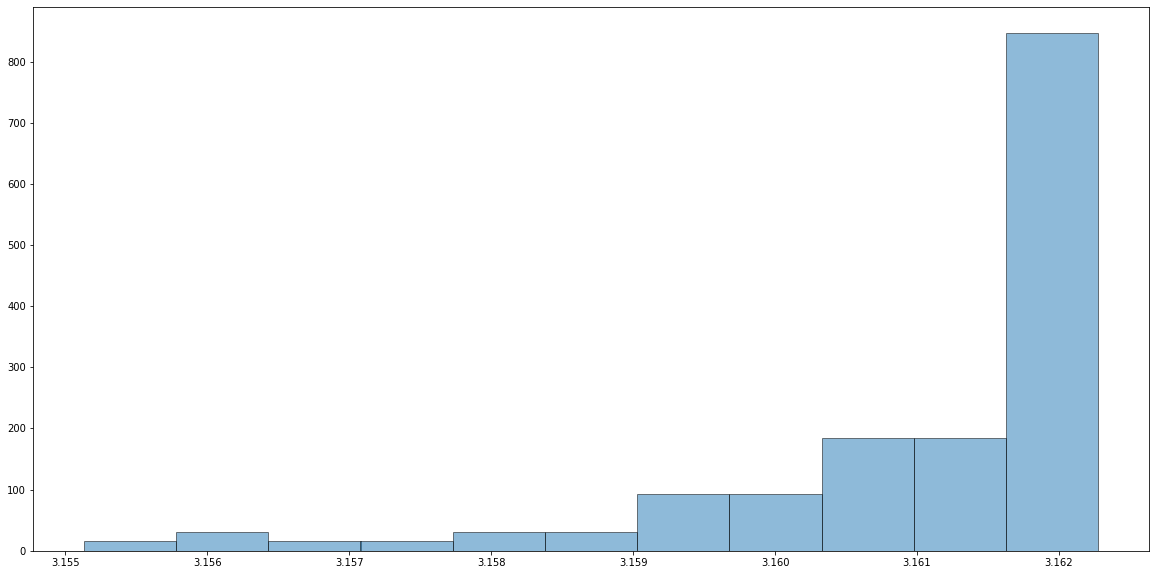

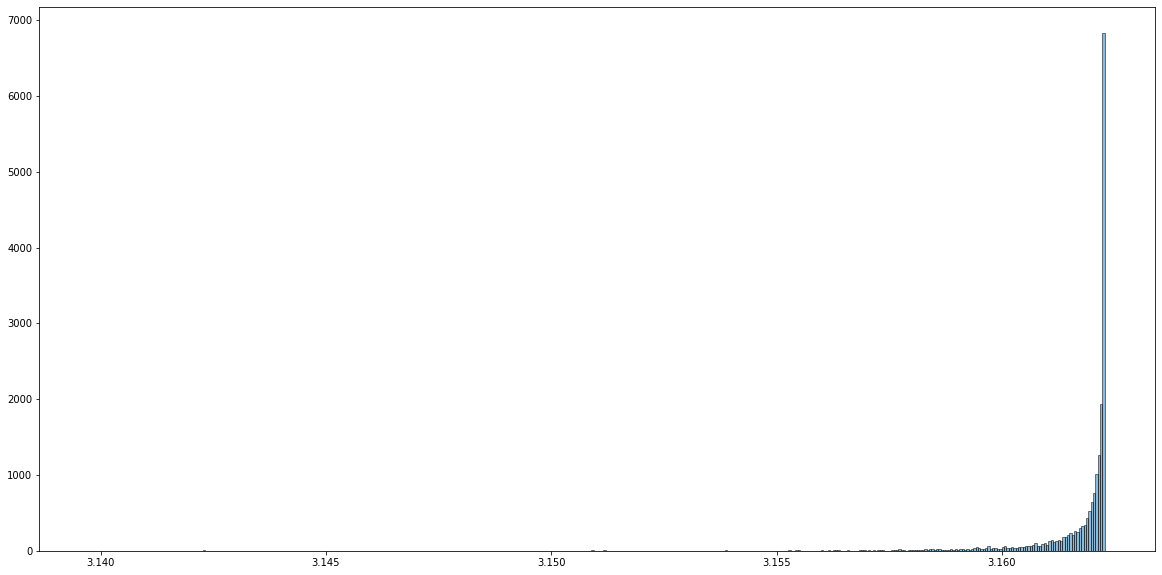

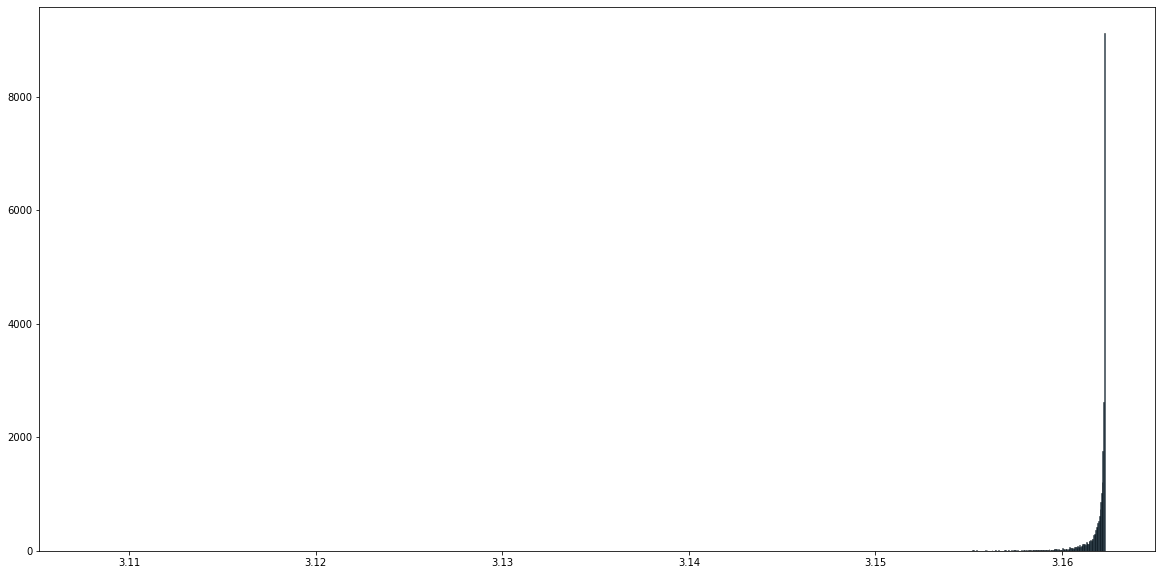

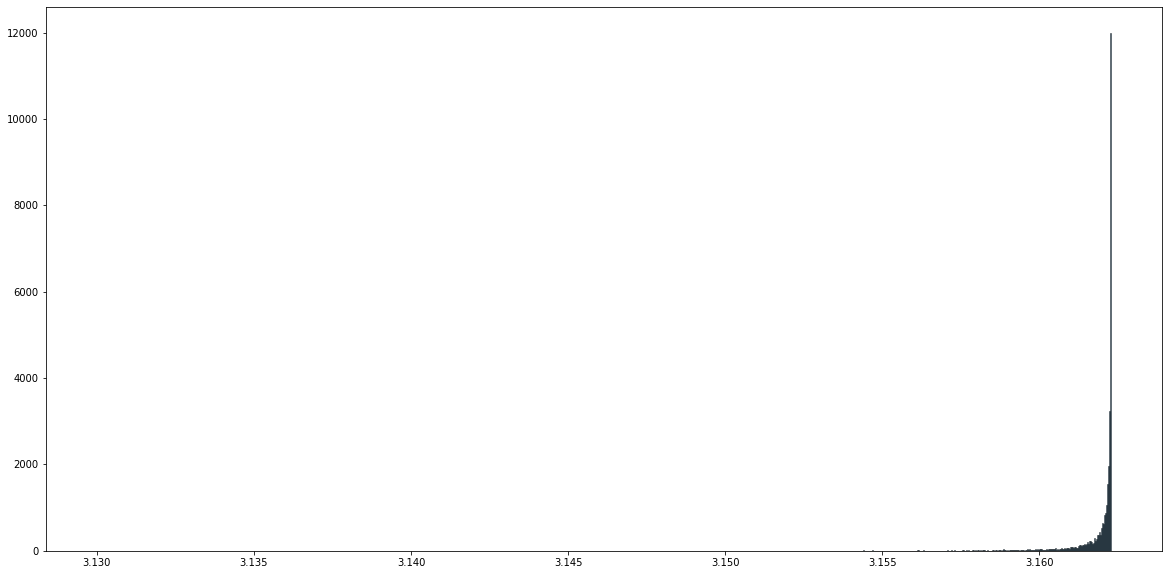

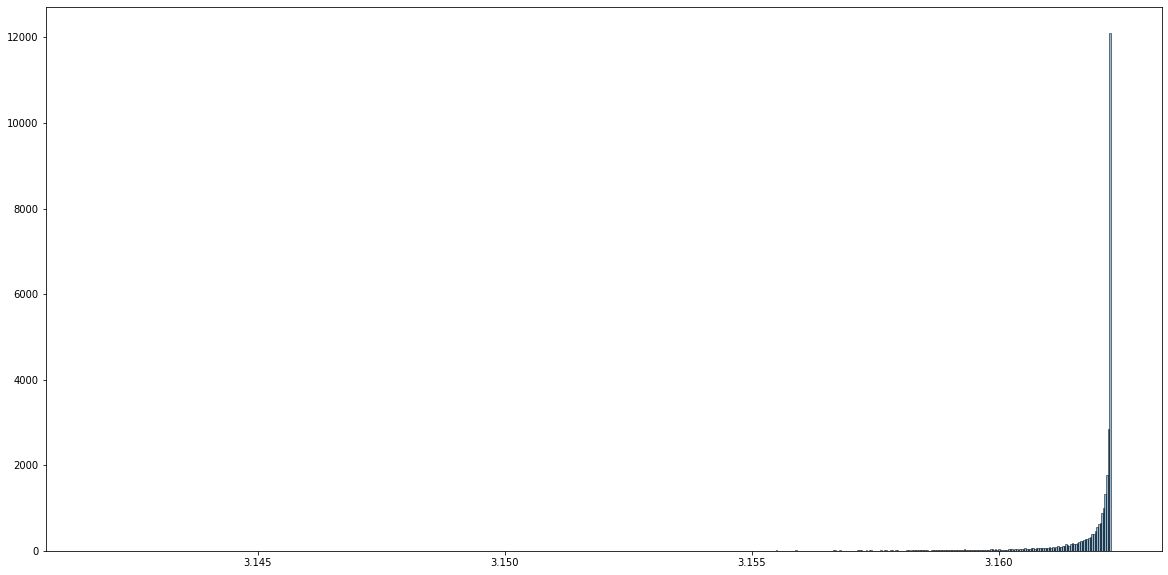

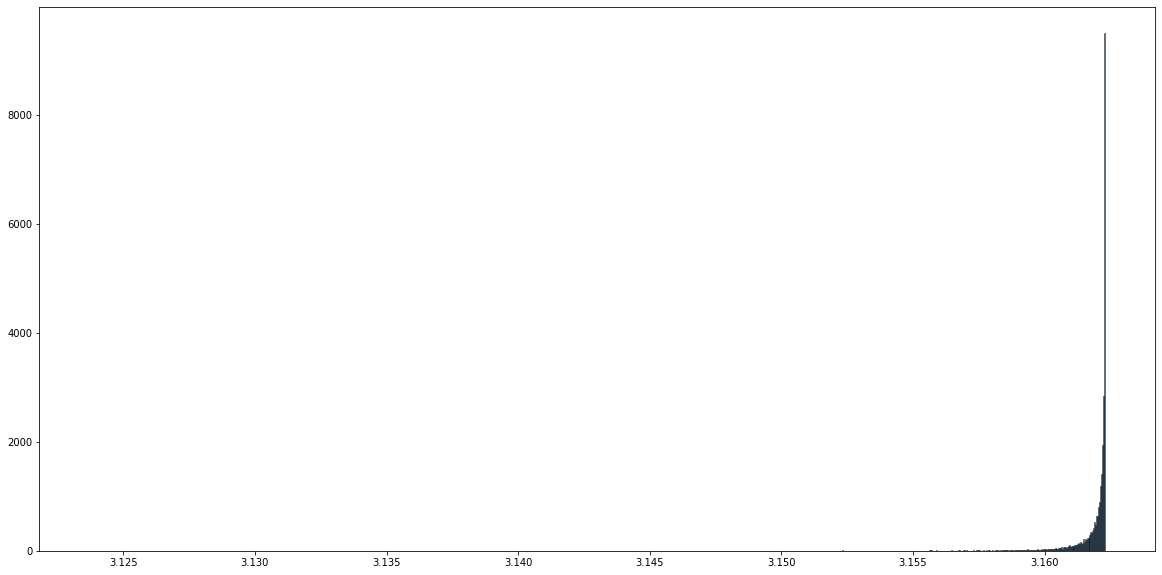

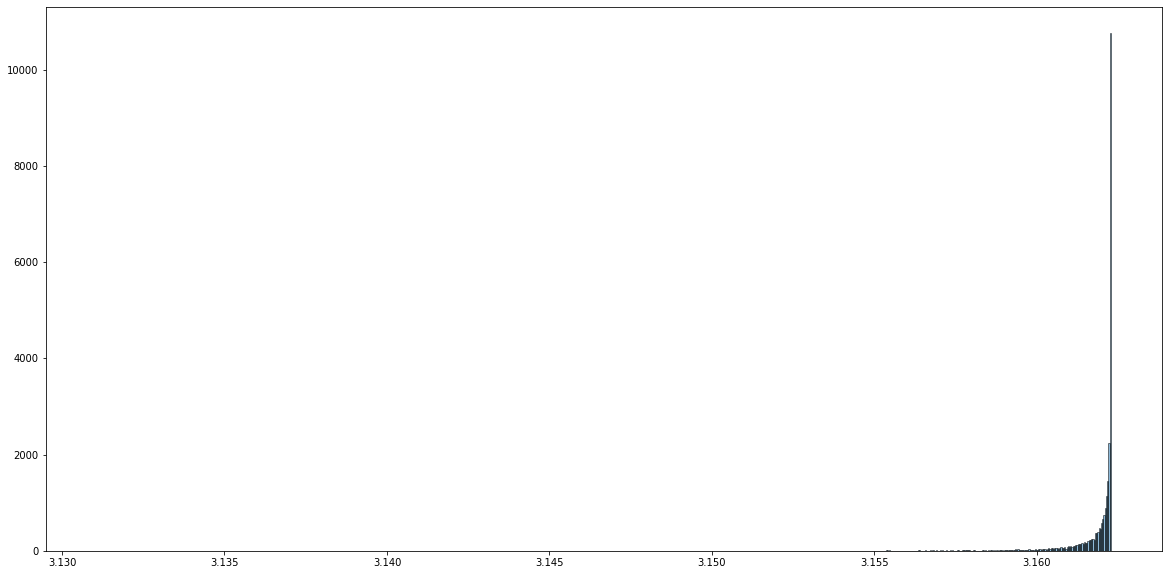

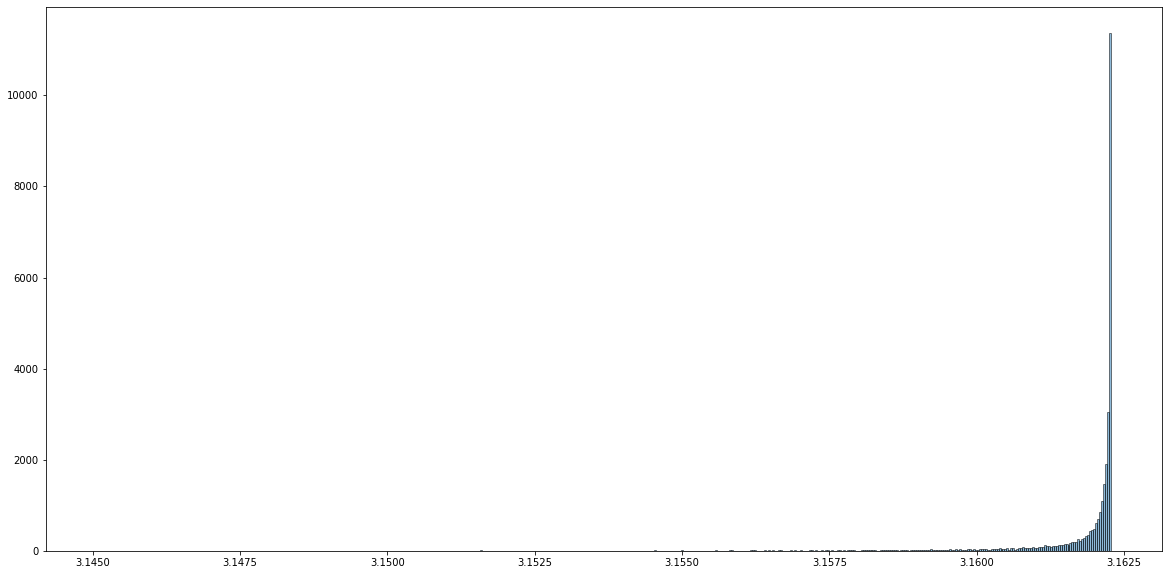

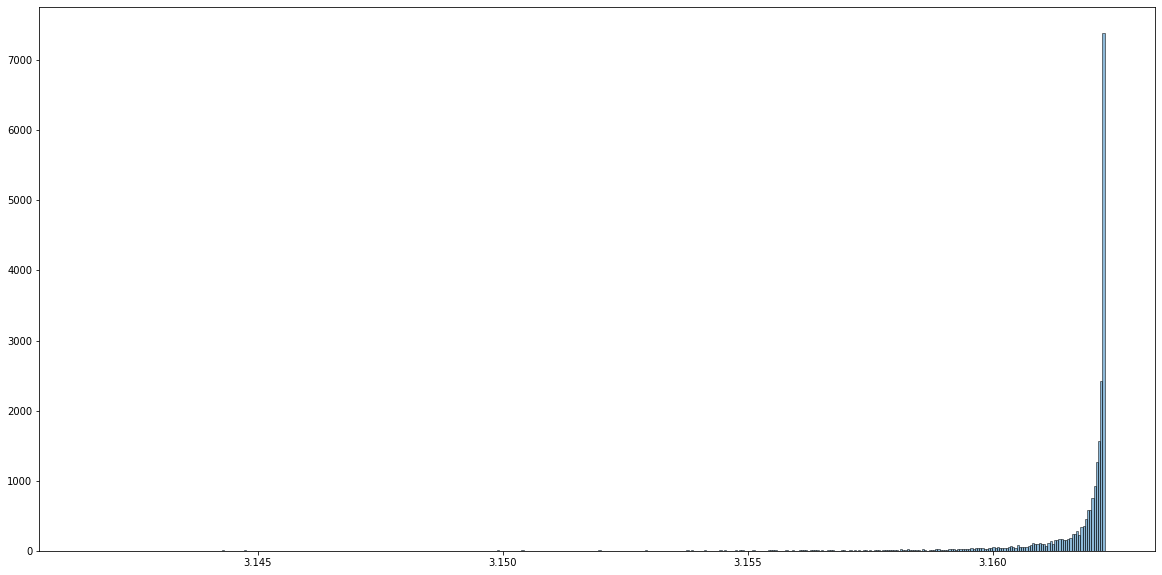

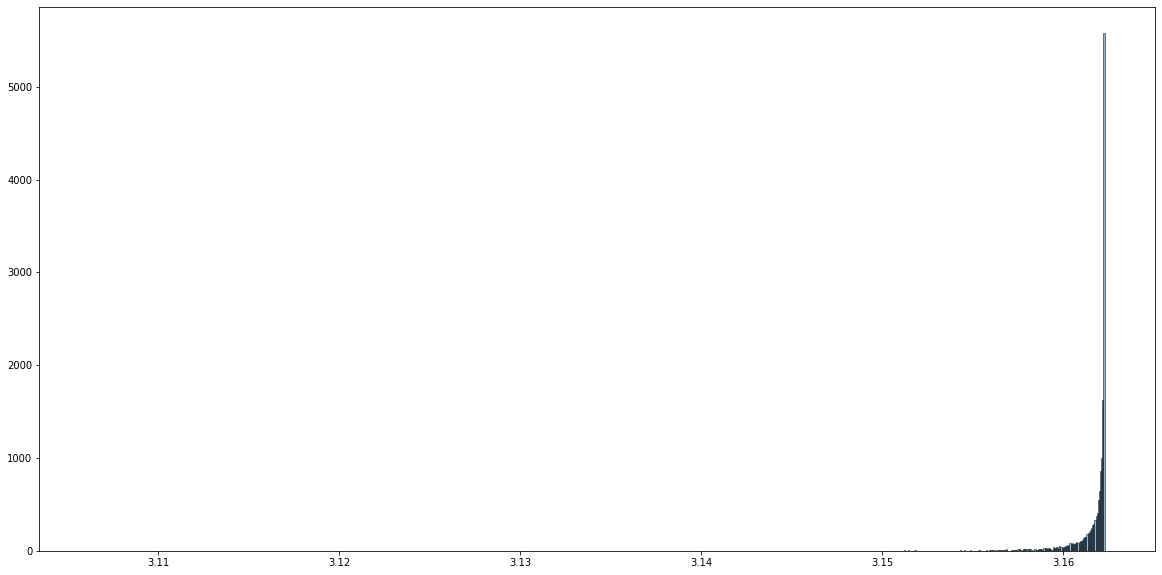

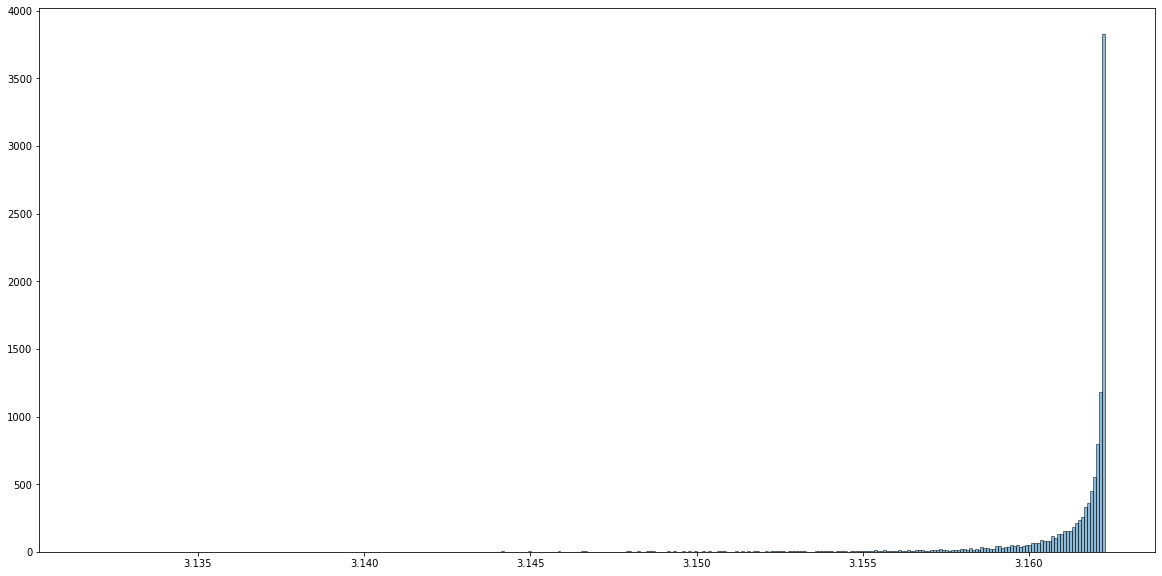

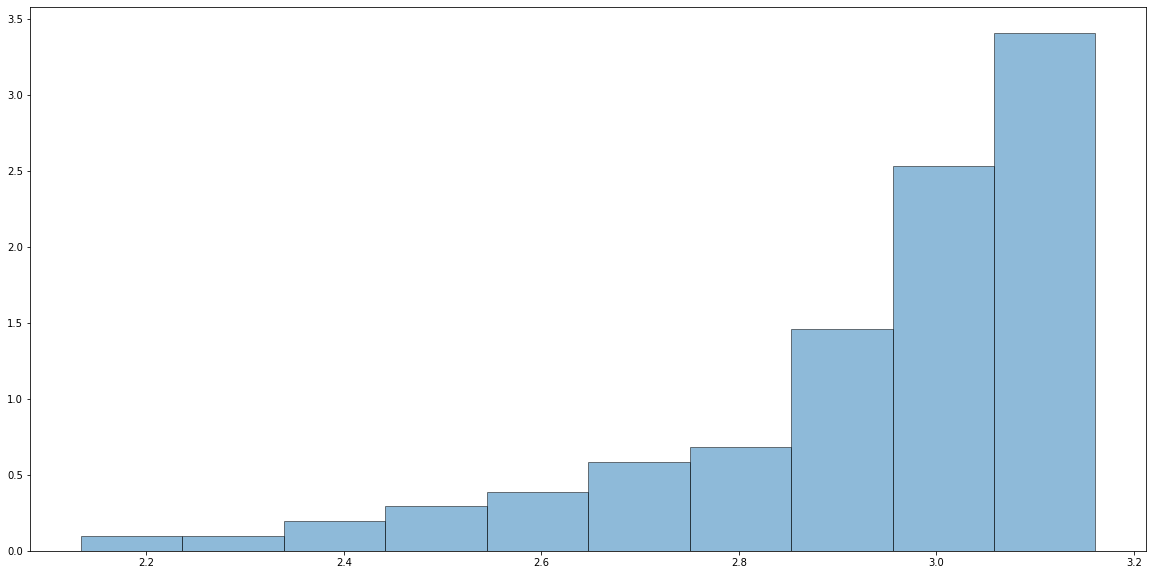

In [22]:
for i, tnsr in enumerate(perceptronDiagH):
    if i%2 == 0:
        plt.hist(torch.flatten(tnsr).detach().numpy(), bins='auto', edgecolor='black', alpha=.5, density=True)
        plt.show()

0.weight


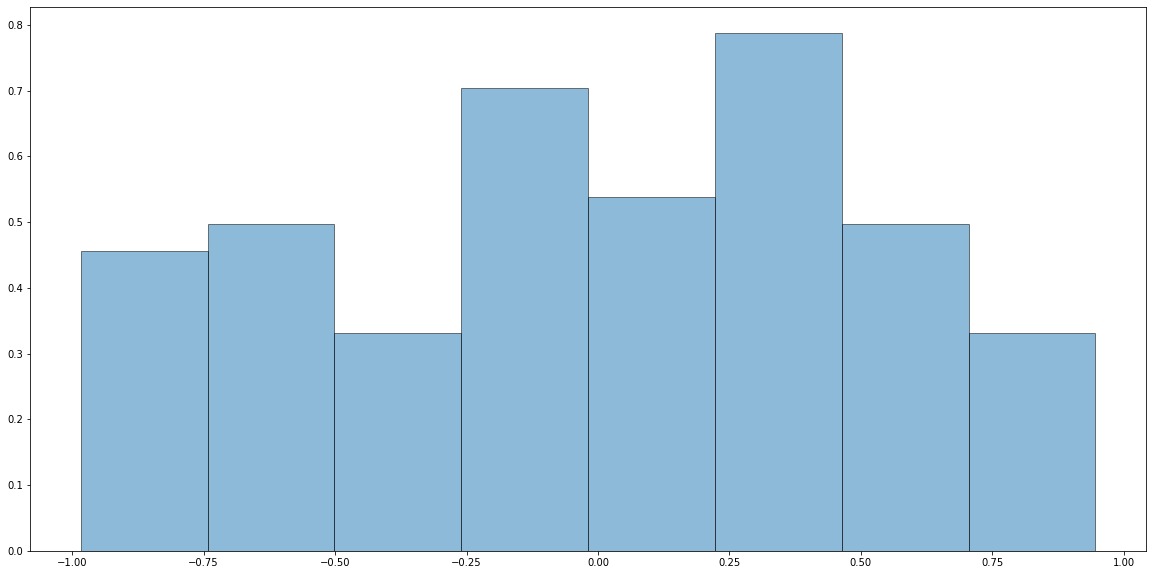

1.weight


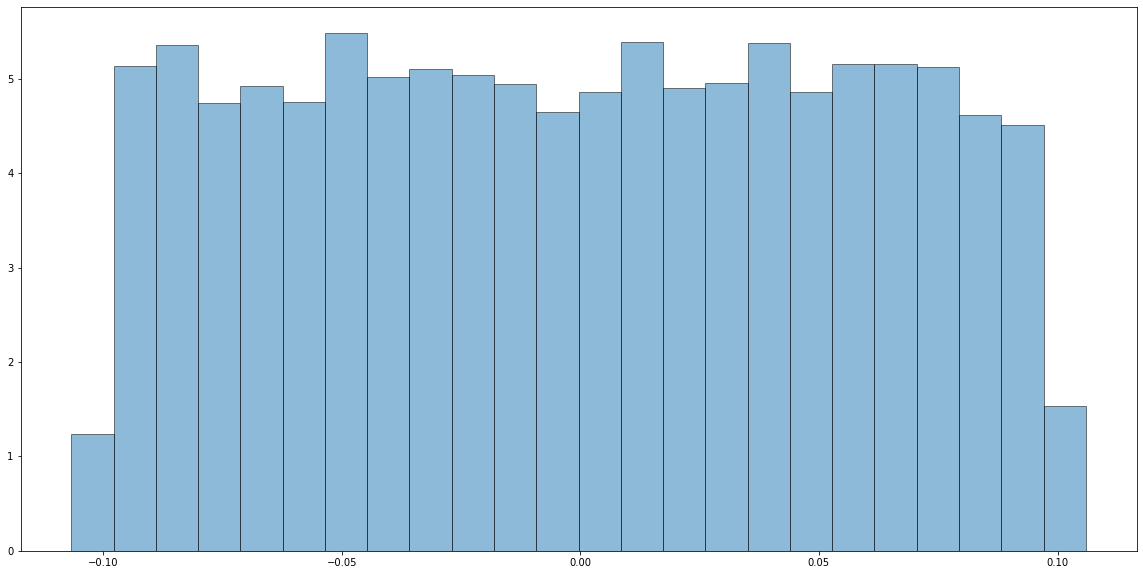

2.weight


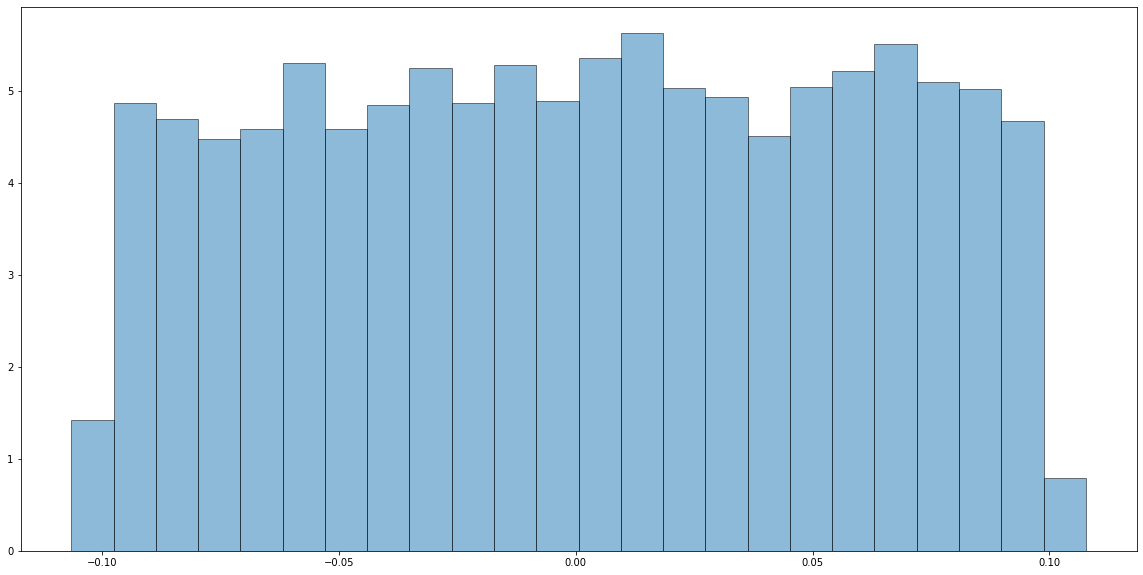

3.weight


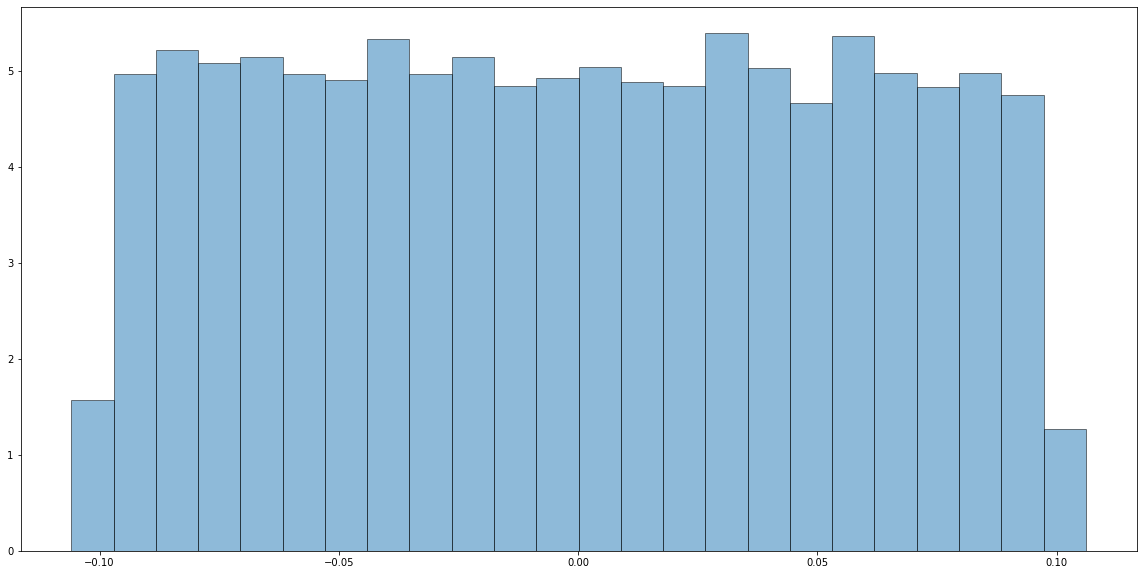

4.weight


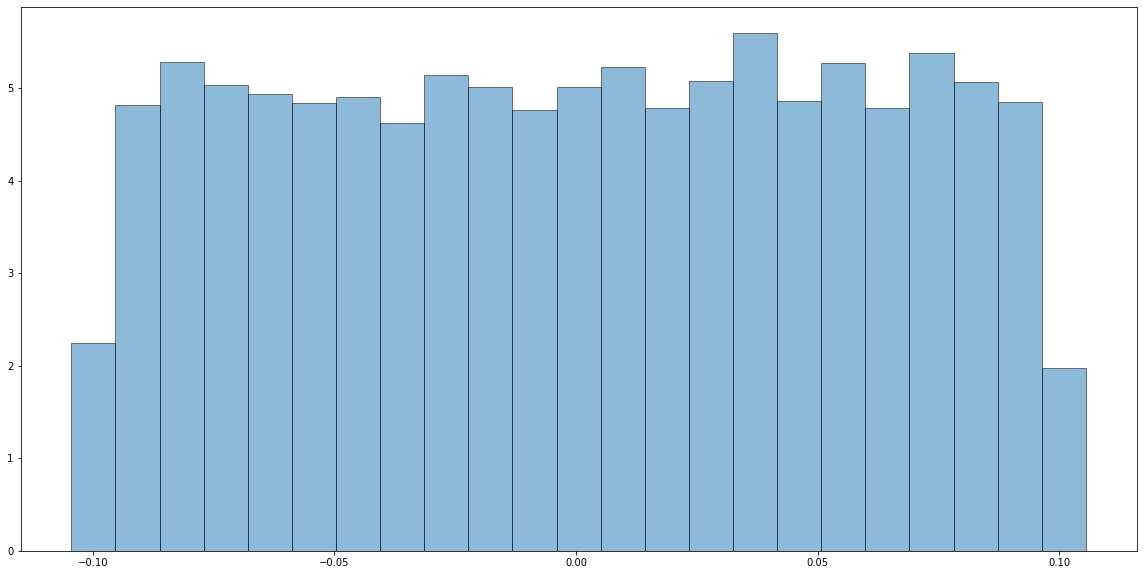

5.weight


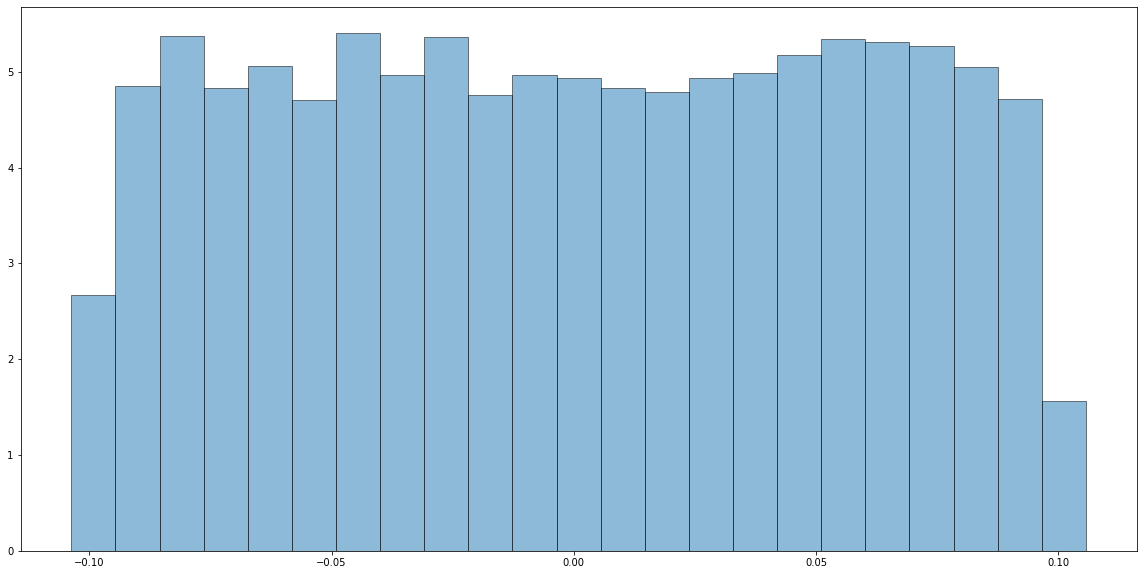

6.weight


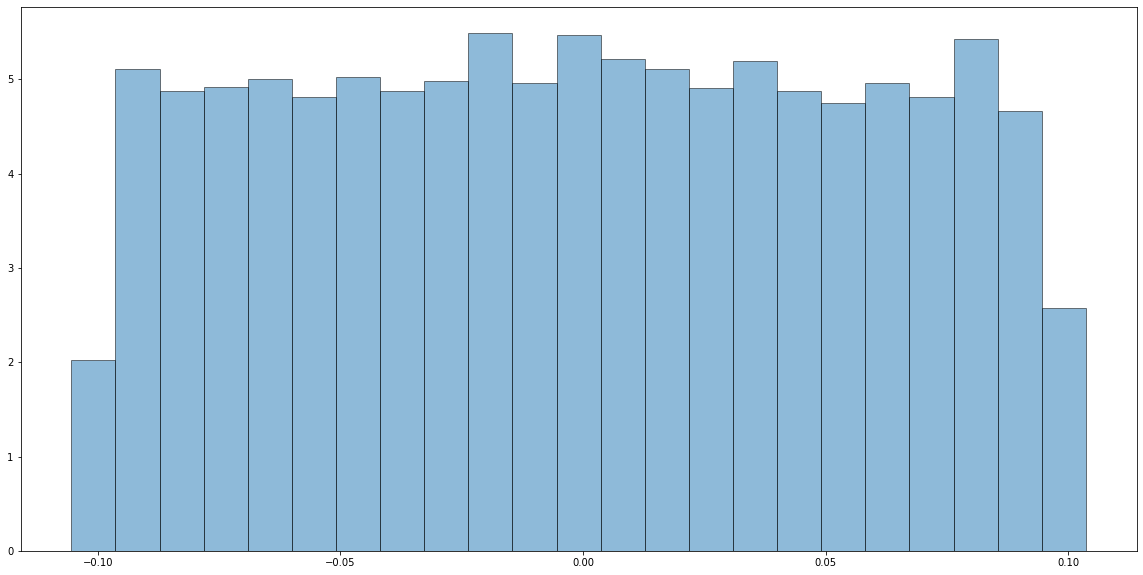

7.weight


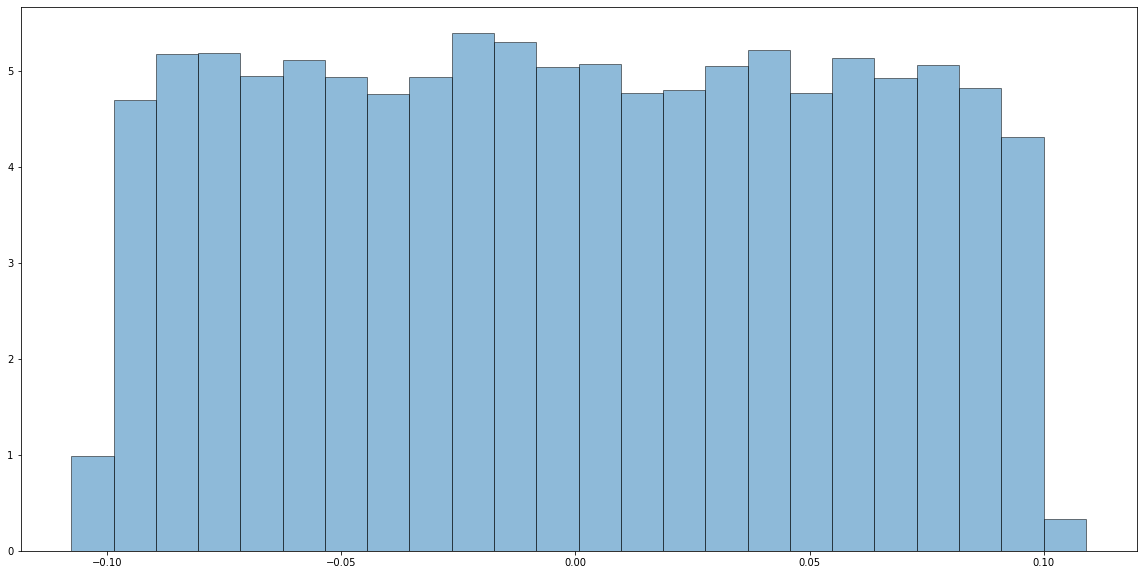

8.weight


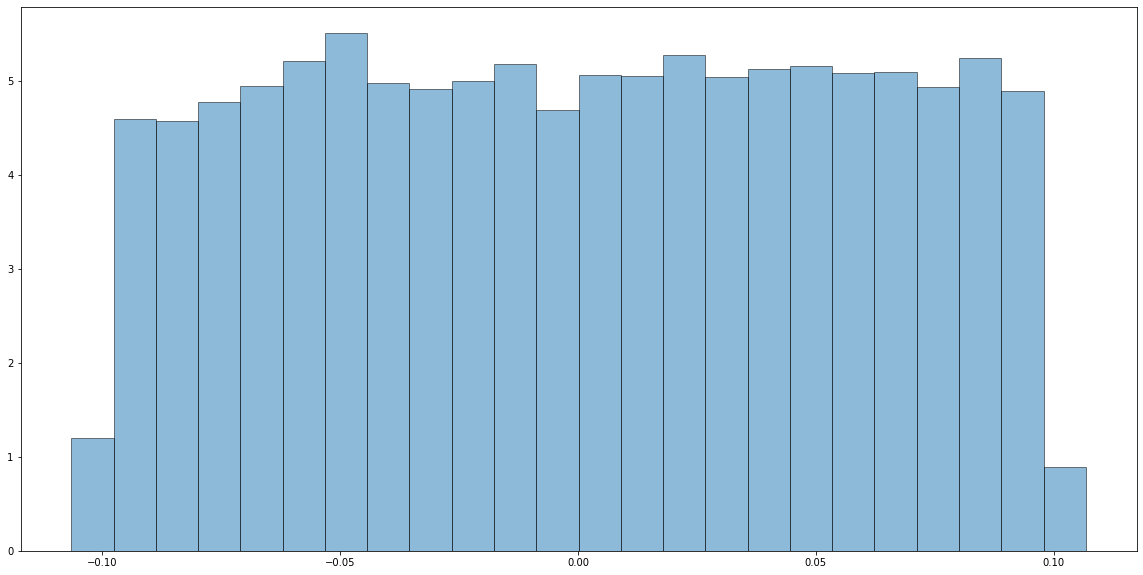

9.weight


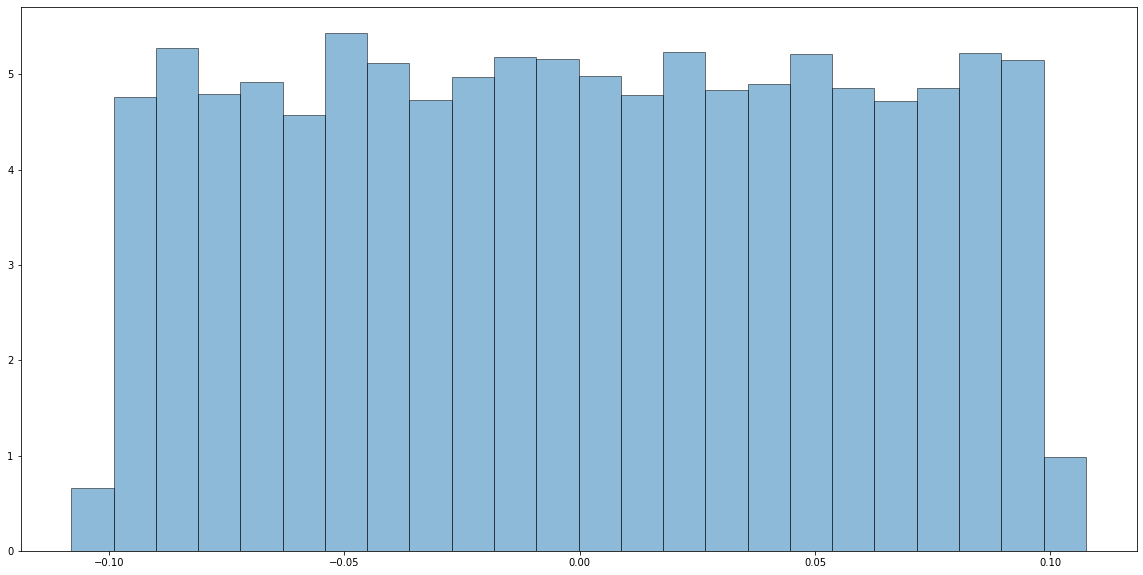

10.weight


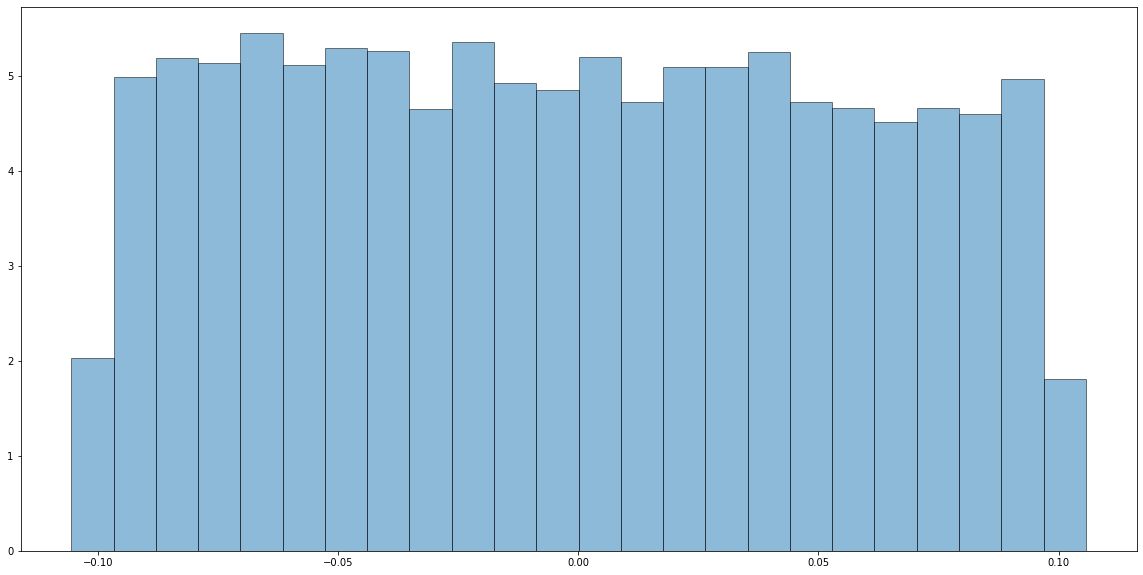

11.weight


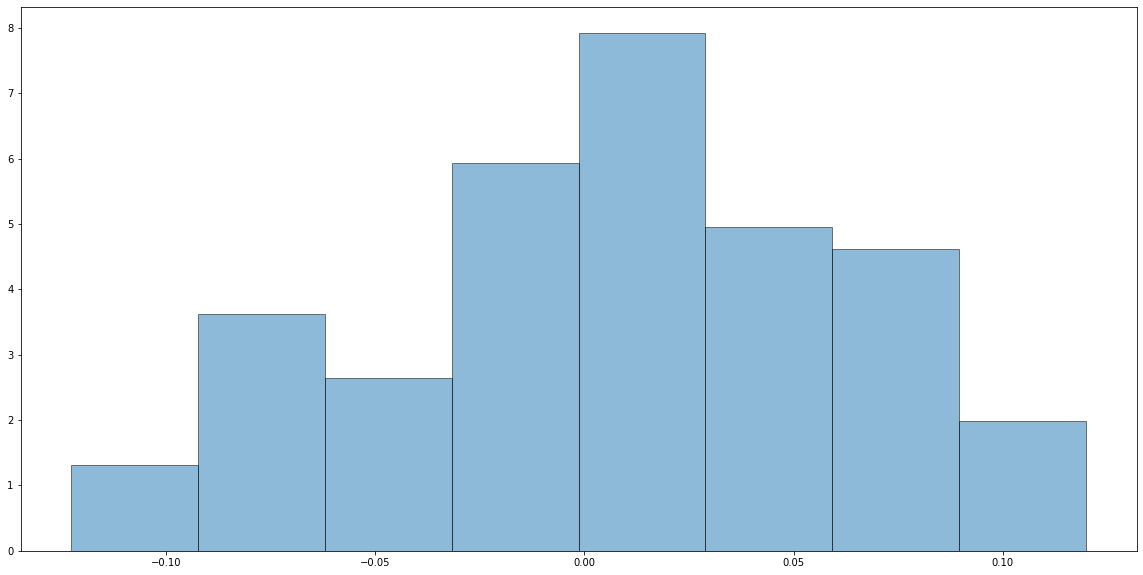

In [23]:
for i, (name, param) in enumerate(net.named_parameters()):
    if i%2 == 0:
        print(name)
        plt.hist(torch.flatten(param).detach().numpy(), bins='auto', edgecolor='black', alpha=.5, density=True)
        plt.show()

layer index: 0
layer name: 0.weight
torch.Size([100, 1]) torch.Size([100, 1])

Pearsons correlation: 0.141


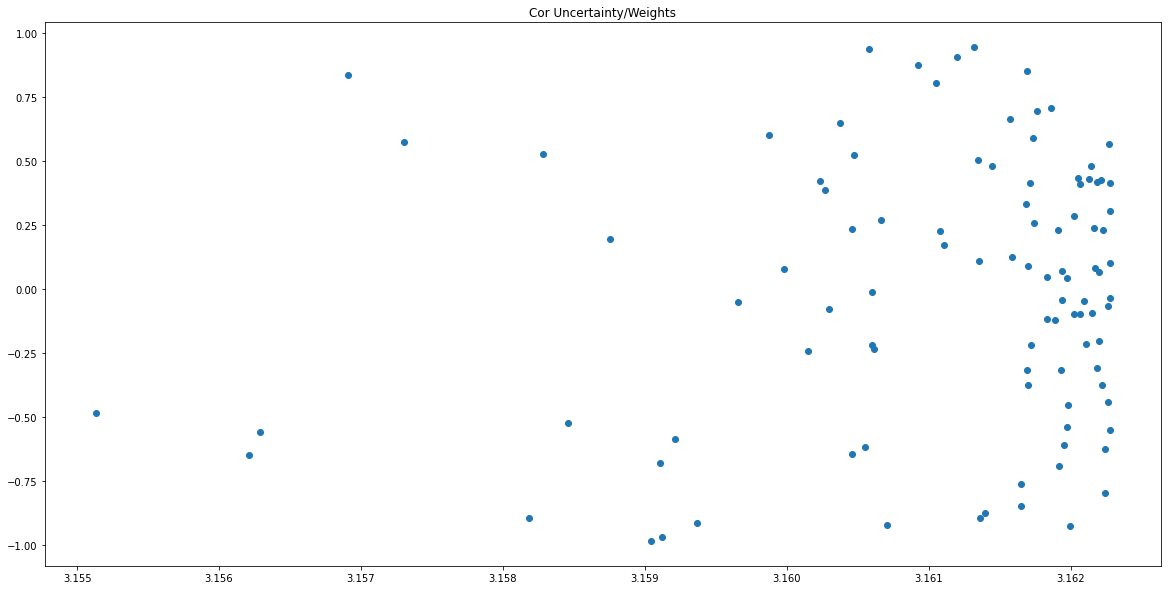

layer index: 2
layer name: 1.weight
torch.Size([100, 100]) torch.Size([100, 100])

Pearsons correlation: 0.000


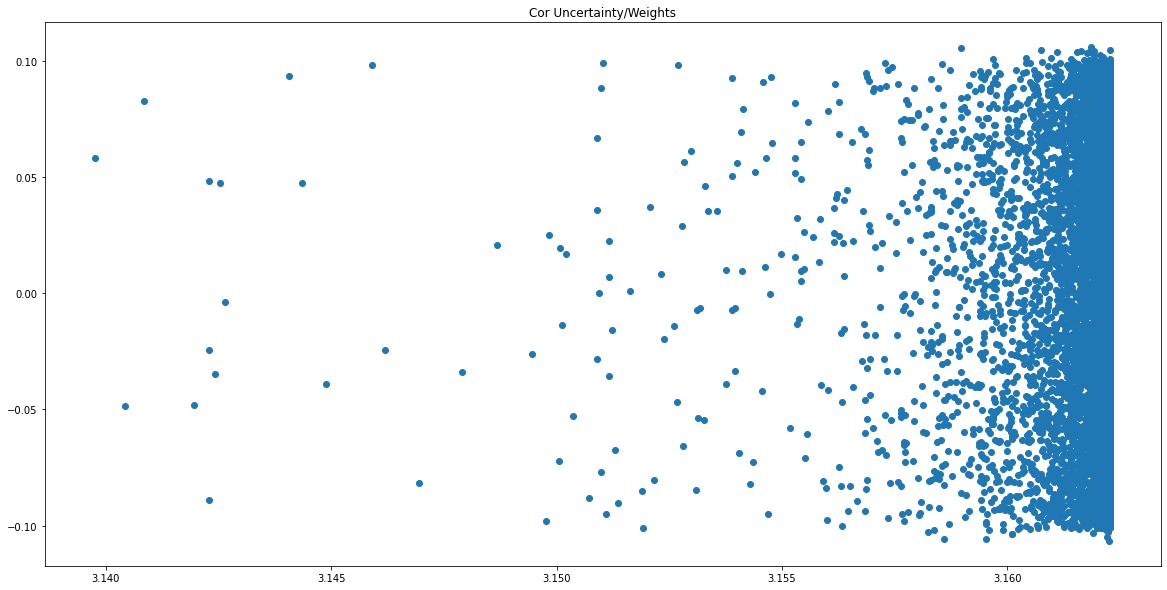

layer index: 4
layer name: 2.weight
torch.Size([100, 100]) torch.Size([100, 100])

Pearsons correlation: 0.010


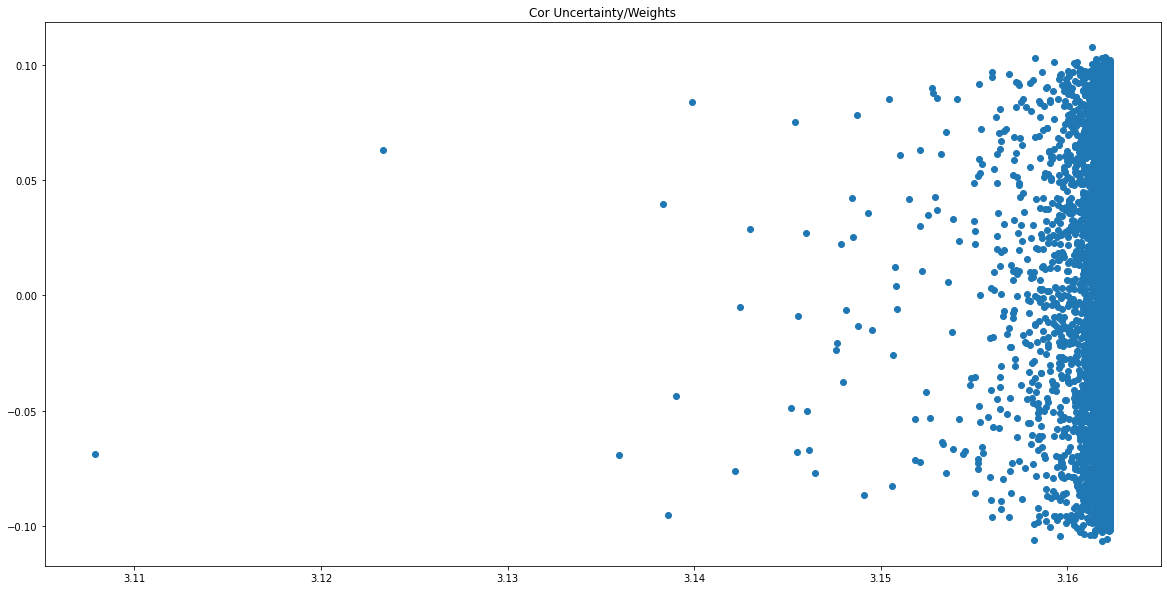

layer index: 6
layer name: 3.weight
torch.Size([100, 100]) torch.Size([100, 100])

Pearsons correlation: -0.004


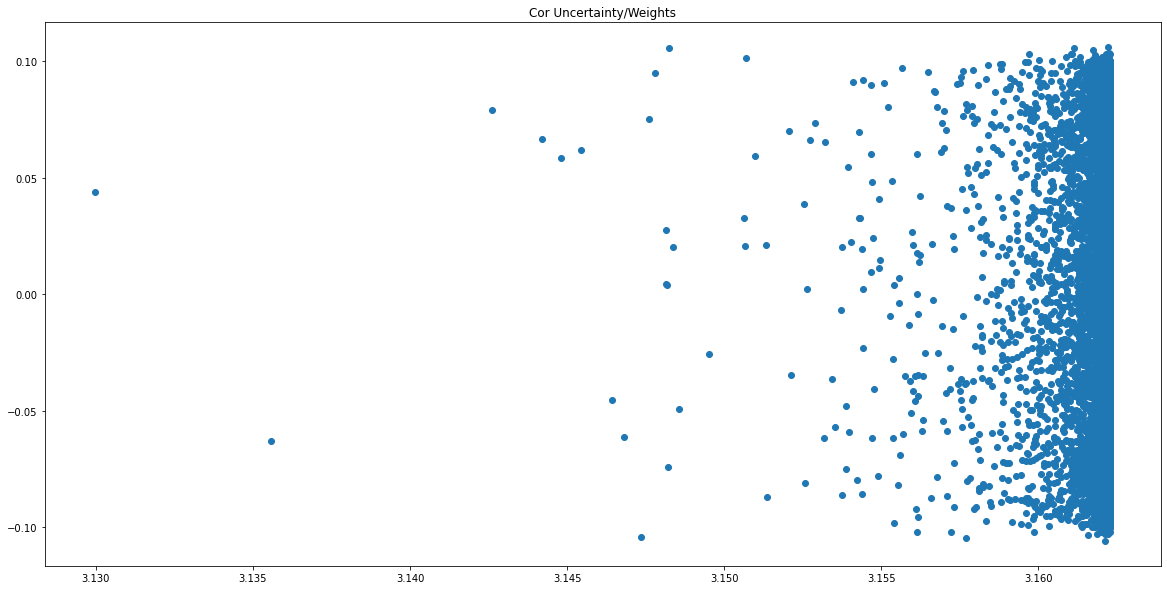

layer index: 8
layer name: 4.weight
torch.Size([100, 100]) torch.Size([100, 100])

Pearsons correlation: 0.004


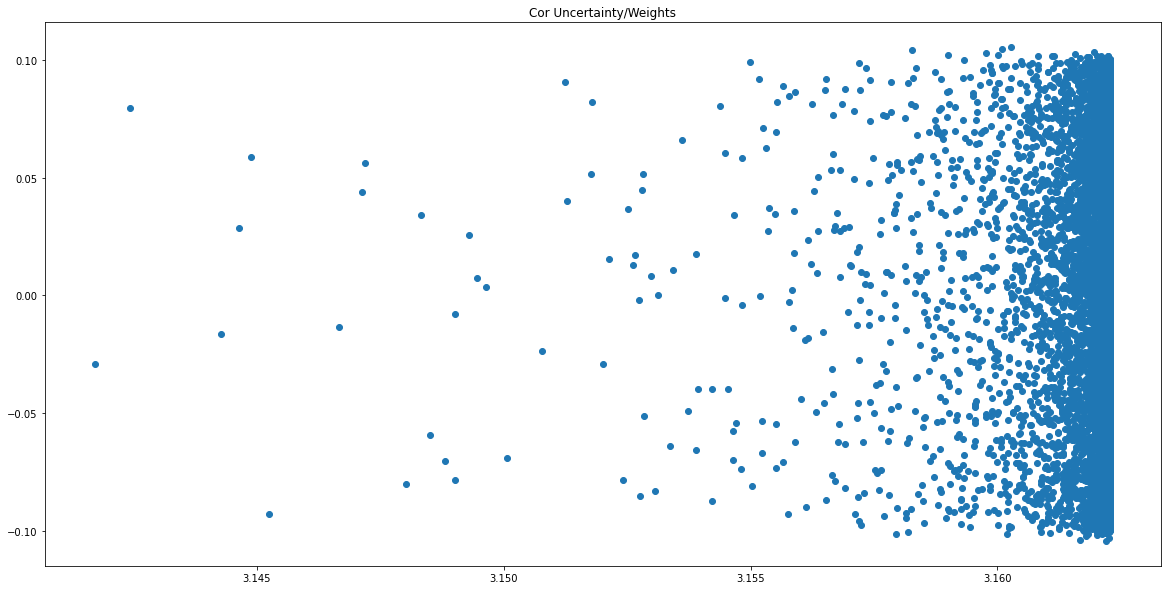

layer index: 10
layer name: 5.weight
torch.Size([100, 100]) torch.Size([100, 100])

Pearsons correlation: 0.007


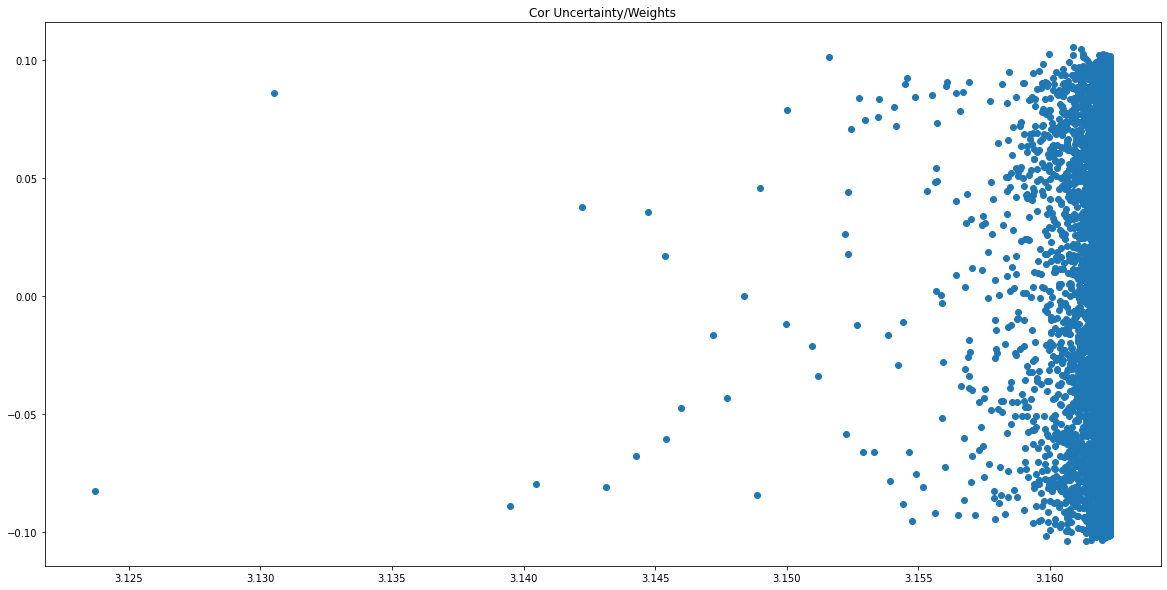

layer index: 12
layer name: 6.weight
torch.Size([100, 100]) torch.Size([100, 100])

Pearsons correlation: 0.020


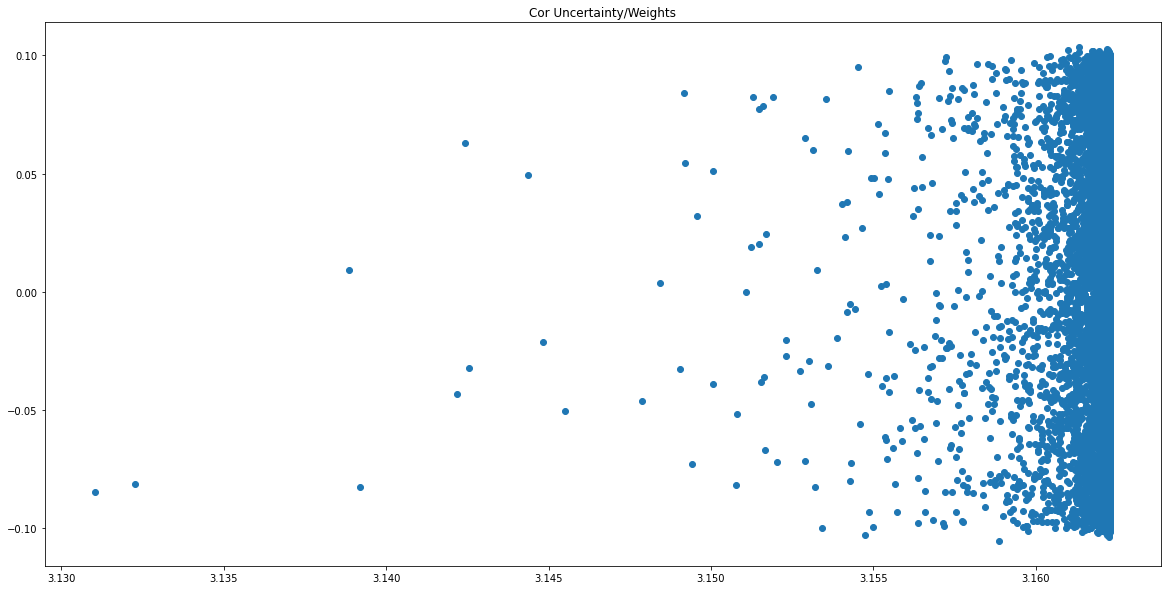

layer index: 14
layer name: 7.weight
torch.Size([100, 100]) torch.Size([100, 100])

Pearsons correlation: 0.002


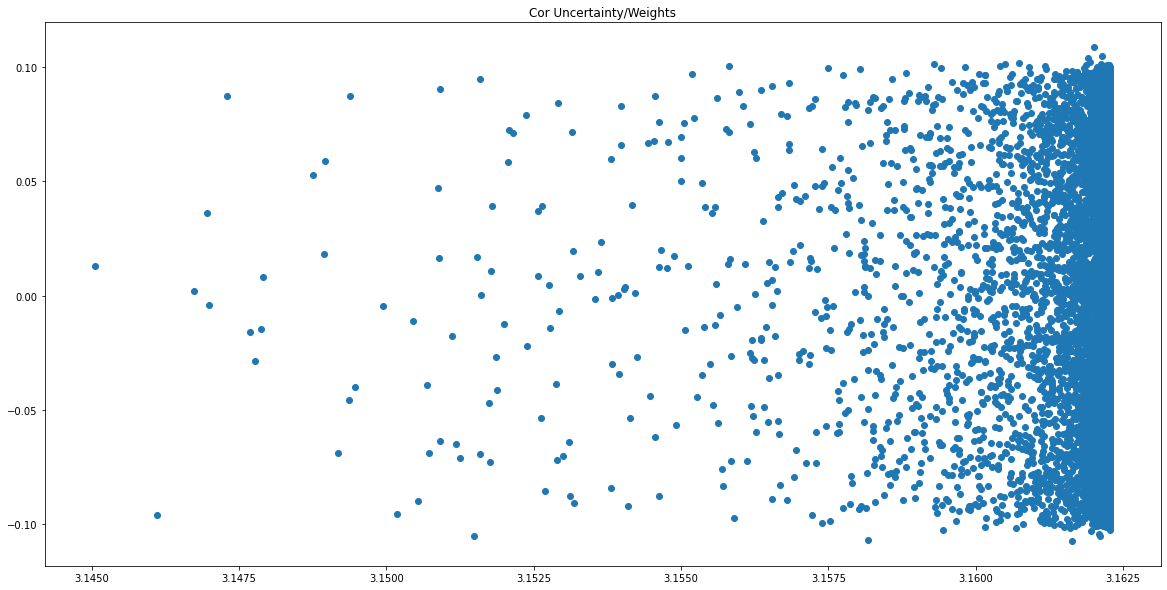

layer index: 16
layer name: 8.weight
torch.Size([100, 100]) torch.Size([100, 100])

Pearsons correlation: 0.004


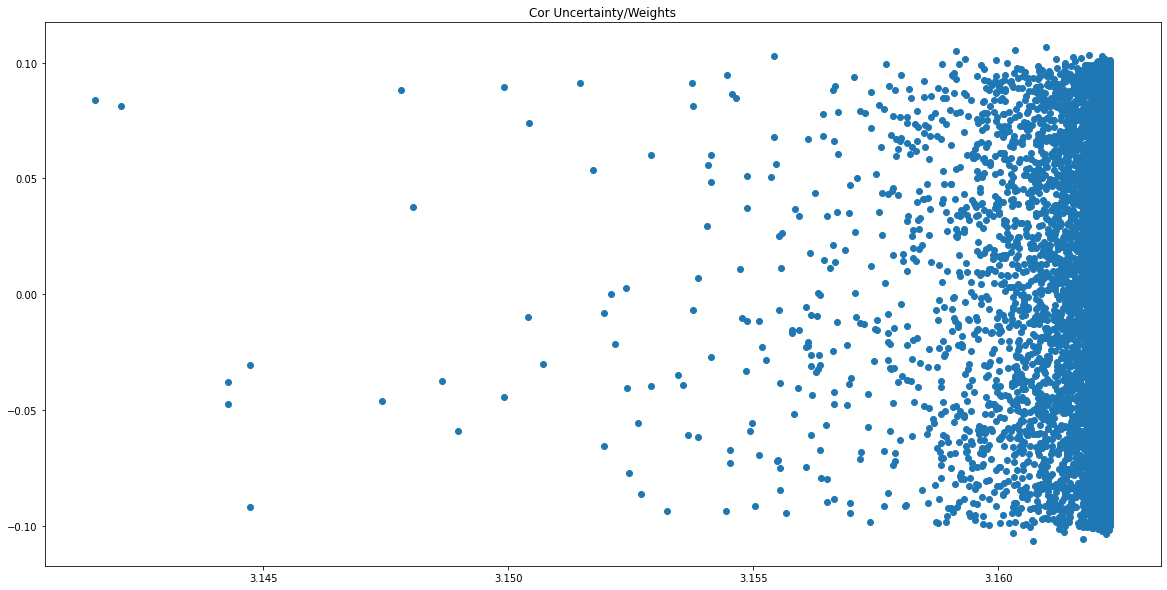

layer index: 18
layer name: 9.weight
torch.Size([100, 100]) torch.Size([100, 100])

Pearsons correlation: -0.007


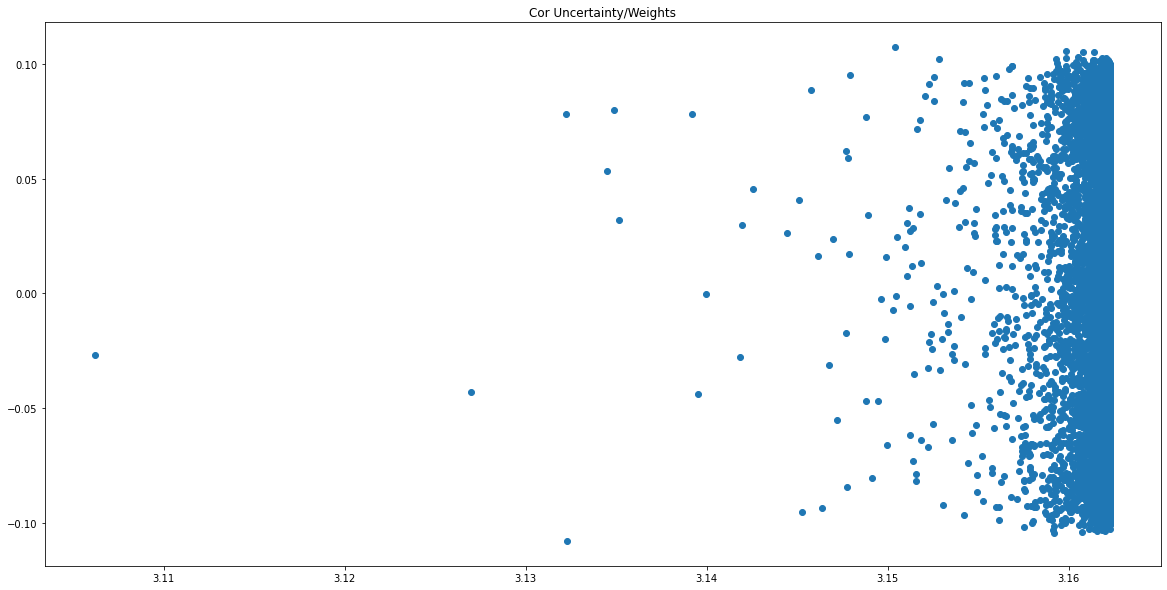

layer index: 20
layer name: 10.weight
torch.Size([100, 100]) torch.Size([100, 100])

Pearsons correlation: 0.001


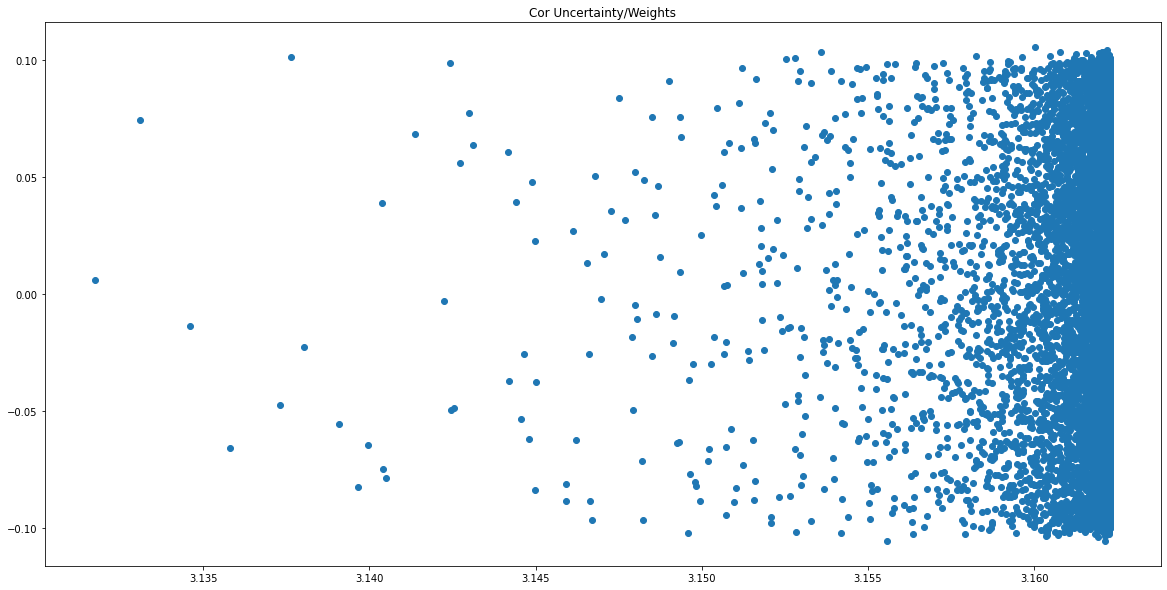

layer index: 22
layer name: 11.weight
torch.Size([1, 100]) torch.Size([1, 100])

Pearsons correlation: 0.135


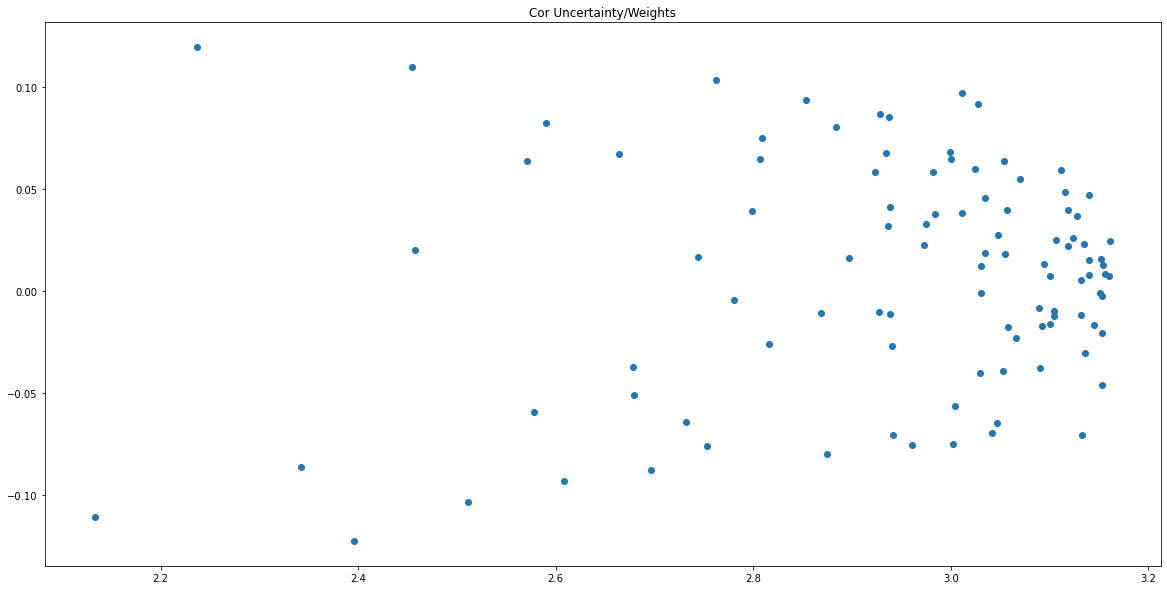

In [24]:
for i, tnsr in enumerate(perceptronDiagH):
    for j, (name, param) in enumerate(net.named_parameters()):
        if i == j and 'weight' in str(name):
            print('layer index: {}'.format(i))
            print('layer name: {}'.format(name))
            print(param.size(), tnsr.size())
            conv2_weights_flattened = torch.flatten(param)
            conv2_uncertainties_flattened = torch.flatten(tnsr)
            plt.scatter(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
            plt.title('Cor Uncertainty/Weights')
            #print(np.cov(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy()))
            corr, _ = pearsonr(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
            print()
            print('Pearsons correlation: %.3f' % corr)
            plt.show()

In [25]:
for i, data4 in enumerate(data):
    X, y = iter(data4)
    if i > 1:
        break
print(X, y)
#X, y = load_mnist_data()
model = extend(net)
lossfunc = extend(torch.nn.MSELoss())
loss = lossfunc(model(torch.tensor([[X]]).float()), torch.tensor([[y]]).float())

#print(model(torch.tensor([[X]]).float()))
print(loss)

with backpack(DiagHessian()):
    loss.backward()

for name, param in model.named_parameters():
    #print(param.grad)
    print(name)
    #print(param.diag_h)

NameError: name 'data' is not defined